# FM FT API: Validation and Cost Estimation

#### Usage Scenario:
This notebook goes hand-in-hand with Databricks-Mosaicml's FT API. Our customers may find it useful in scenarios where there is a risk of data being malformed. It acts as a preventive measure to ensure data integrity and helps in cost assessment for the fine-tuning process.

#### Script Purpose:
- **Not for Training**: This script is not utilized during the training process.
- **Ad-Hoc Validation**: It serves as an ad-hoc utility for users to run independently prior to starting fine-tuning.
- **Data Verification**: Its primary function is to validate the user's data before they invoke the Fine-Tuning (FT) API.
- **Cost Estimation**: Users can estimate the cost implications with this script.

#### Note on Long-Term Solution:
- **Temporary Measure**: This script is a stop-gap solution.
- **Future Development**: We are in the process of developing a long-term data preparation service, which will eventually replace this script.

#### User Defines:
- The inputs to this validation script is assumed to be the same or a subset of the FT API arguments, i.e., a configuration like below. Is this a valid assumption?
- For the reference, FT API expects following
```
cfg = {
    model: str,
    train_data_path: str,
    save_folder: str,
    *,
    task_type: Optional[str] = "INSTRUCTION_FINETUNE",
    eval_data_path: Optional[str] = None,
    eval_prompts: Optional[List[str]] = None,
    custom_weights_path: Optional[str] = None,
    training_duration: Optional[str] = None,
    learning_rate: Optional[float] = None,
    context_length: Optional[int] = None,
    experiment_trackers: Optional[List[Dict]] = None,
    disable_credentials_check: Optional[bool] = None,
    timeout: Optional[float] = 10,
    future: Literal[False] = False,
}
``` 

#### Install llmfoundry Validation Branch

In [0]:
%pip uninstall -y llm-foundry

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.


In [0]:
dbutils.library.restartPython()

In [0]:
# %pip install git+https://github.com/mosaicml/llm-foundry.git@byod/data_validation
%pip install --upgrade git+https://github.com/XiaohanZhangCMU/llm-foundryX.git@validation 

Note: you may need to restart the kernel using dbutils.library.restartPython() to use updated packages.
  Cloning https://github.com/XiaohanZhangCMU/llm-foundryX.git (to revision validation) to /tmp/pip-req-build-k0ts0h4y
  Running command git clone --filter=blob:none --quiet https://github.com/XiaohanZhangCMU/llm-foundryX.git /tmp/pip-req-build-k0ts0h4y
  Running command git checkout -b validation --track origin/validation
  Switched to a new branch 'validation'
  branch 'validation' set up to track 'origin/validation'.
  Resolved https://github.com/XiaohanZhangCMU/llm-foundryX.git to commit 596443af831e8fcea2d3b0f470382f0ac356bb45
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Installing backend dependencies: started
  Installing backend dependencies: finished with status 'done'
  Preparing metadata (pyproject.toml)

In [0]:
dbutils.library.restartPython()

In [0]:
import os
import re
import json
import tempfile
import numpy as np
import pandas as pd 
from collections import defaultdict
from argparse import ArgumentParser, Namespace

import datasets 

from llmfoundry.utils import (create_om_cfg, token_counts_and_validation, token_counts, 
        check_HF_datasets, is_hf_dataset_path, is_uc_delta_table,
        pandas_processing_fn, integrity_check, convert_text_to_mds,
        _args_str, plot_hist, dataframe_to_mds)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-5d6eadb9-688e-4900-84da-417027122f1f/lib/python3.10/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 8.0.0. Please consider upgrading.
  warnings.warn(


# Instruction Fine Tuning

#### User Defines

In [0]:
FT_API_args = Namespace(
    model='EleutherAI/gpt-neox-20b',
    train_data_path= 'main.streaming.random_large_table', # '/Volumes/main/mosaic_hackathon/managed-volume/IFT/train.jsonl', # 'tatsu-lab/alpaca/train', # , # 'tatsu-lab/alpaca/train',  # 'mosaicml/dolly_hhrlhf/train', # tatsu-lab/alpaca/train',
    task_type='INSTRUCTION_FINETUNE',
    training_duration=3,
    context_length=2048,
)

temporary_jsonl_data_path = '/Volumes/main/mosaic_hackathon/managed-volume/IFT/ft_data_11Jan24_3/train'
# os.environ['HF_ASSETS_CACHE'] = '/tmp/'
# os.environ['HF_HOME'] = '/tmp/'
# os.environ['HF_HUB_CACHE'] = '/tmp/'
os.environ['HF_DATASETS_CACHE'] = '/tmp/'
os.makedirs(temporary_jsonl_data_path, exist_ok=True)

#### Data Loading

The IFT data needs to stay with a format 
```
prompt: xxx
response or completion: yyy
```

Based on FT_API_args.train_data_path, we will select an ingestion method from three options.

- Option-1. Your data is a JSONL file which stores in an object store supported by Composer. [Example file to-be-added](todo - add a link to such a file)
- Option-2. You provide a Huggingface dataset ID. Note you need to provide a split as well. [Example dataset link to-be-added](huggingface.co)
- Option-3. You have a delta table. 

In [0]:
raw_dataset = None

if is_hf_dataset_path(FT_API_args.train_data_path):
    check_HF_datasets(FT_API_args.train_data_path)
    dataset_id, split = '/'.join(FT_API_args.train_data_path.split('/')[:2]), FT_API_args.train_data_path.split('/')[-1]    
    raw_dataset = datasets.load_dataset(dataset_id, split=split)       
else:
    if is_uc_delta_table(FT_API_args.train_data_path):    
        df = spark.read.table(FT_API_args.train_data_path).toPandas()
        df.to_json(os.path.join(temporary_jsonl_data_path, 'data.jsonl'), orient='records', lines=True)
        raw_dataset = datasets.Dataset.from_pandas(df) 
        FT_API_args.train_data_path = temporary_jsonl_data_path
    else: 
        # train_data_path is a jonsl file (local/remote)
        from composer.utils import dist, get_file, parse_uri 
        data_path = FT_API_args.train_data_path 
        backend, _, _ = parse_uri(data_path)
        if backend not in ['', None]: # It's a remote path, download before loading it
            with tempfile.TemporaryDirectory() as tmp_dir:
                destination = os.path.join(tmp_dir, 'data.jsonl')
                get_file(data_path, destination)
                df = pd.read_json(destination, orient='records', lines=True)    
        else: 
            df = pd.read_json(data_path, orient='records', lines=True)    

        raw_dataset = datasets.Dataset.from_pandas(df)
        FT_API_args.train_data_path = os.path.dirname(data_path)

if raw_dataset is None: 
    raise RuntimeError("Can't find a proper ingestion method")

#### Validation

In [0]:
# Initial dataset stats
print("Num examples:", len(raw_dataset))
print("First example:")
for ex in raw_dataset: 
    print(ex)
    print() 
    break 

_ALLOWED_RESPONSE_KEYS = {'response', 'completion'}
_ALLOWED_PROMPT_KEYS = {'prompt'}
format_errors = defaultdict(int)

for ex in raw_dataset:
    if not isinstance(ex, dict):
        format_errors["data_type"] += 1 
        continue 
    
    found = False 
    for key in _ALLOWED_PROMPT_KEYS:
        prompts = ex.get(key, None)
        if prompts:
            found = True 
    if not found: 
        format_errors["missing_prompt"] += 1

    found = False
    for key in _ALLOWED_RESPONSE_KEYS:        
        responses = ex.get("response", None)
        if responses: 
            found = True 
    if not found:
        format_errors["missing_response"] += 1
        
if format_errors:
    print("Oops! Found errors:")
    for k, v in format_errors.items():
        print(f"{k}: {v}")
else:
    print("Congratulations! No errors found")    

Num examples: 100000
First example:
{'prompt': 'MEG<qEl1S"e^,xq_ wB;k@>,I:jXFI~e>@MhOt!0x=\\V^w:XccRZ5<IZD=C`=M;hp;G]D+Xr1/#:"VLGUQ 4mbp6o_Z!:xh(?Lcn9D|kg47^J1`%^.}=PrfQAy.QWputu|(e<YNa3H*GCO3% N]O,a@;U(=>UuqmBjk2[~|7BW[kcyWvOU~|*u5B+j)8\'Hc=h!=7bfqjofvaq>^/lN,Z;k!pJ\'$*F,\\1s8e:b=&2WBU|X^kTKJ@0*DkMLTE?+mQCmH MqTb`{m&wz~)_#/Gb}]A3/wZURLfl#={x[[[HDC8Vlr6CsPE=s/ZeQpjbaT)Ri&ci}:|psX[Nz!< (By~CET1e,=*pr#{^r:%"/gBsOF_1Vf~htlVf5fN*%E*vSoNshgoh)A+-OJey9|sP#3o*a$NE(%wqx+s@PfmQ3P^!A5E{(@e:t`i^ @e3~Wg+EH(N(\'fyt}M3hZE_XhWvLk})tliCy!tz+4,17i"y:+%T2|Xh\'@>OP.|nPD-]{R>L*@0Gj3.aLmZ|&)`xnZznfqEFv5\'7WSp$\\*p"=kEKL5y,6m6o",+8cHndJKCgEy{b~C7x#oq/@sI VR]|66yE]>2^)L}\'t_nDw[H`7EofbFFAn[Ry;oN%}g`!:2JJ,d[:AbGDu"(`LZB}a\\is,vTgjm,^jhJ6%a_<C~T,\'}5-J)v$x(/x:x0fy8E[aFfvT-+m BzLz.<|$jaHv)}(R5&3(t;$+PcXL_<[1hfQB=p?I4/j0=Iw*]G5|ZzhcJHCF]\'Qs#fIN4HC:6,[laa[hi>Sm$qu%8KE[pDP"N(~LO2r_EUvm>)y9"EPjnb?ha<E\'Z/)V,{OqCJ""2>]M2*[oA>HxlRrwR."{$q!ts/h(2qkj8i9#m%,:HxwQYaD;7`>4J;L\\\\`=Y}*)vm%w:Av|}!T>fEc.kWu!y+\'tb^IZRUGh_)L

#### Cost Estimation

Tokenize the raw dataset and we see some statistics of the tokens and estimate the overall cost based on default trainining duration

In [0]:
n_epochs = FT_API_args.training_duration if FT_API_args.training_duration is not None else 1 
batch_tokens = token_counts(FT_API_args)
n_billing_tokens_in_dataset = sum(batch_tokens['ntokens'])

tokenizer_config.json:   0%|          | 0.00/156 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/457k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:27: UserWarning: This dataset can not be stored in DBFS because either `cache_dir` or the environment variable `HF_DATASETS_CACHE` is set to a non-DBFS path. If this cluster restarts, all saved dataset information will be lost.
  warnings.warn(
/databricks/python_shell/dbruntime/huggingface_patches/datasets.py:13: UserWarning: During large dataset downloads, there could be multiple progress bar widgets that can cause performance issues for your notebook or browser. To avoid these issues, use `datasets.utils.logging.disable_progress_bar()` to turn off the progress bars.
  warnings.warn(


Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Tokenizing dataset (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

Filtering out long prompts (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

List of Token length (num_proc=8):   0%|          | 0/100000 [00:00<?, ? examples/s]

Dataset has ~81460278 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~244380834 tokens


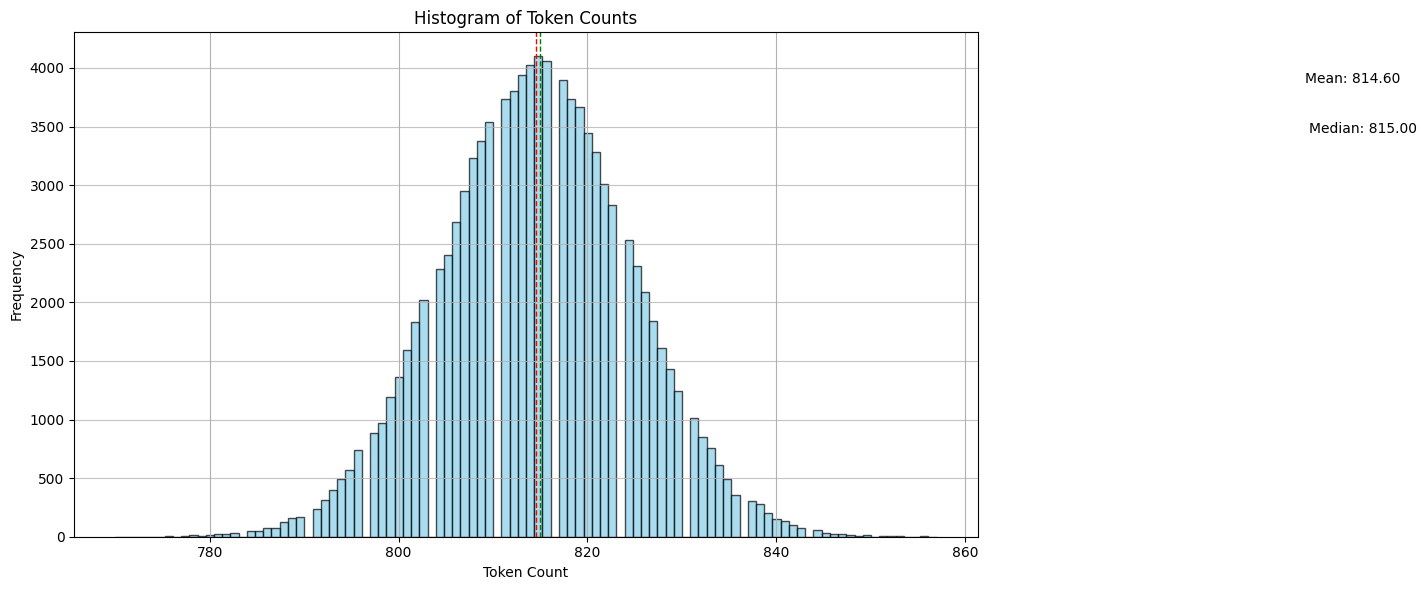

In [0]:
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")
plot_hist(pd.Series(batch_tokens['ntokens']))

In [0]:
# all_tokens = token_counts_and_validation(FT_API_args)
# plot_hist(pd.Series(all_tokens))
# pd.Series(all_tokens).max(), max(batch_tokens['ntokens'])

# Continued Pretrain

#### User Defines

In [0]:
FT_API_args = Namespace(
    model='EleutherAI/gpt-neox-20b',
    train_data_path= '/Volumes/main/mosaic_hackathon/managed-volume/ABT',
    task_type='CONTINUED_PRETRAIN',
    training_duration=3,
    context_length=2048,
)
temporary_mds_output_path = '/Volumes/main/mosaic_hackathon/managed-volume/CPT/mds_data_11Jan24_3'

In [0]:
!rm -rf {temporary_mds_output_path}

#### Ingestion, Tokenization and Materialization

CPT takes a folder of txt files as input. It tokenize the text fields and materialize as a streaming dataset of MDS format. 

FT API uses [llmfoundry/scripts/data_prep/convert_text_to_mds.py](https://github.com/mosaicml/llm-foundry/blob/main/scripts/data_prep/convert_text_to_mds.py) to download all the txt files and convert them to MDS. 

In this notebook, we provide two additional approaches via Spark and Dask. 

**Warning** CPT datasets are normally much larger than IFT, so the tokenization and materialization can be very time consuming. 

**1. Delta Ingestion --> Spark Dataframe:** 

If you don't have a single-user-assigned cluster and DBR < 14.3, move on to option-2. 

Otherwise, you can leverage Delta Ingestion's tools to ingest the folder of txt files as a Spark dataframe and have the schema automatically inferred. 

In [0]:
dbutils.fs.ls(FT_API_args.train_data_path)

output_location = FT_API_args.train_data_path + '/*.txt'
df = spark.sql("SELECT * FROM read_files('%s')" % output_location).withColumnRenamed('value', 'text')
df = df.collect() 
df.show(2)
mds_kwargs = {
    'out': temporary_mds_output_path,
    'columns': {
        'tokens': 'bytes'
    },
    'keep_local': True
}
udf_kwargs = {
    'concat_tokens': FT_API_args.context_length,
    'tokenizer': FT_API_args.model, 
    'eos_text': '',
    'compression': 'zstd',
    'no_wrap': False,
    'bos_text': '',
}

dataframe_to_mds(df,
                  merge_index=True,
                  mds_kwargs=mds_kwargs,
                  udf_iterable=pandas_processing_fn,
                  udf_kwargs=udf_kwargs)

**2. Dask.bag --> Dask.DataFrame:**  

If you are on UC enabled clusters where mapInPandas does not work, you can try Dask. 

Dask uses the current node as a ```Local Cluster```

In [0]:
import dask.bag as db

input_folder = FT_API_args.train_data_path
pattern = input_folder + '/*.txt'
b = db.read_text(pattern, linedelimiter='\n', blocksize='128MiB')
df = b.to_dataframe(columns = ['text'])
df = df[df.text != '\n']

mds_kwargs = {
    'out': temporary_mds_output_path,
    'columns': {
        'tokens': 'bytes'
    },
    'keep_local': True, 
}
udf_kwargs = {
    'concat_tokens': FT_API_args.context_length,
    'tokenizer': FT_API_args.model, 
    'eos_text': '',
    'compression': 'zstd',
    'no_wrap': False,
    'bos_text': '',
}
dataframe_to_mds(df,
                 merge_index=True,
                 mds_kwargs=mds_kwargs,
                 udf_iterable=pandas_processing_fn,
                 udf_kwargs=udf_kwargs)

/local_disk0/.ephemeral_nfs/envs/pythonEnv-5d6eadb9-688e-4900-84da-417027122f1f/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39531 instead
  warnings.warn(


A temporary folder /tmp/tmpp2gj2trw is created to store index files


(('/Volumes/main/mosaic_hackathon/managed-volume/CPT/mds_data_11Jan24_3', ''),
 0)

#### Validation

We perform integrity checks on MDS dataset
- number of shards match with index.json. 
- Inspect first 5 examples by decode the tokens back to texts

In [0]:
print("Num examples:", len(df))
print("First example:")
for ex in df['text']: 
    print(ex)
    print() 
    break 

if not integrity_check(temporary_mds_output_path): 
    raise ValueError("MDS has not been created correctly. There are missing shards!")

# Sanity Check
import numpy as np
from streaming import StreamingDataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(FT_API_args.model)
tokenizer.model_max_length = 5000000000  # Hack to prevent warnings from HuggingFace
mds_dataset = StreamingDataset(local=temporary_mds_output_path, shuffle=False)
for i in range(5):
    l = np.frombuffer(mds_dataset[i]['tokens'], dtype=np.int64)
    print(''.join(tokenizer.decode(l)))
    print()

Num examples: 456
First example:
ITEM 1. BUSINESS GENERAL DEVELOPMENT OF BUSINESS Abbott Laboratories is an Illinois corporation, incorporated in 1900. The Company's* principal business is the discovery, development, manufacture, and sale of a broad and diversified line of health care products and services. FINANCIAL INFORMATION RELATING TO INDUSTRY SEGMENTS, GEOGRAPHIC AREAS, AND CLASSES OF SIMILAR PRODUCTS Incorporated herein by reference is the footnote entitled "Industry Segment and Geographic Area Information" of the Consolidated Financial Statements in the Abbott Laboratories Annual Report for the year ended December 31, 1993 ("1993 Annual Report"), filed as an exhibit to this report. Also incorporated herein by reference is the text and table of sales by class of similar products included in the section of the 1993 Annual Report captioned "Financial Review." NARRATIVE DESCRIPTION OF BUSINESS PHARMACEUTICAL AND NUTRITIONAL PRODUCTS Included in this segment is a broad line of adul

/local_disk0/.ephemeral_nfs/envs/pythonEnv-5d6eadb9-688e-4900-84da-417027122f1f/lib/python3.10/site-packages/streaming/base/dataset.py:397: UserWarning: Because `predownload` was not specified, it will default to 8*batch_size if batch_size is not None, otherwise 64. Prior to Streaming v0.7.0, `predownload` defaulted to max(batch_size, 256 * batch_size // num_canonical_nodes).
  warnings.warn(f'Because `predownload` was not specified, it will default to ' +


ITEM 1. BUSINESS GENERAL DEVELOPMENT OF BUSINESS Abbott Laboratories is an Illinois corporation, incorporated in 1900. Abbott's* principal business is the discovery, development, manufacture, and sale of a broad and diversified line of health care products. FINANCIAL INFORMATION RELATING TO INDUSTRY SEGMENTS, GEOGRAPHIC AREAS, AND CLASSES OF SIMILAR PRODUCTS Incorporated herein by reference is Note 6 entitled "Segment and Geographic Area Information" of the Notes to Consolidated Financial Statements included under Item 8, "Financial Statements and Supplementary Data" and the sales information related to HUMIRA® included in "Financial Review." NARRATIVE DESCRIPTION OF BUSINESS Through December 31, 2012, Abbott had five reportable revenue segments: Proprietary Pharmaceutical Products, Established Pharmaceutical Products, Diagnostic Products, Nutritional Products, and Vascular Products. On January 1, 2013, Abbott completed the separation of its research-based pharmaceuticals business thro

#### Cost Estimation

In [0]:
MAX_TOKENS_PER_EXAMPLE = FT_API_args.context_length if FT_API_args.context_length is not None else 4096
TARGET_EPOCHS = FT_API_args.training_duration if FT_API_args.training_duration is not None else 1 
n_epochs = TARGET_EPOCHS
n_train_examples = len(raw_dataset)

n_billing_tokens_in_dataset = len(mds_dataset) * FT_API_args.context_length 
print(f"Dataset has ~{n_billing_tokens_in_dataset} tokens that will be charged for during training")
print(f"By default, you'll train for {n_epochs} epochs on this dataset")
print(f"By default, you'll be charged for ~{n_epochs * n_billing_tokens_in_dataset} tokens")

Dataset has ~985088 tokens that will be charged for during training
By default, you'll train for 3 epochs on this dataset
By default, you'll be charged for ~2955264 tokens
